# Brief:

In this notebook, by using highly imbalanced credit card fraud data, we explore if Data Balancing or Model Calibration will help improve our Gradient Boosted tree based classificaiton model.

#### We demonstrated techniques listed below:

    1. Grid Search for optimal gradient boosted tree model parameters
    2. Confusion Matrix
    3. Normalized Confusion Matrix (unbalanced test data)
    4. Cross-validation Score + Testing Accuracy/F1 Score
    5. Classification Report
    6. Precison-Recall Curve
    7. ROC and AUC
    8. Calibration Curve/ Reliability Diagram
    9. Calibrated Model improvement
    

#### Conclusion:

In our gradient boosted tree model, 
1. Grid-search Cross-Validation recommended model did not perform well 
2. Calibrated model significantly improved model performance through observing ROC curve and Precision-Recall curve

Therefore, we will choose calibration to improve our Gradient Boosted tree model performance


In [1]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier


from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split


from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, f1_score

import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



In [2]:
creditcard = pd.read_csv('C:/Users/liuhu/Documents/Python/creditcard.csv')
creditcard['hour'] = creditcard['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)

In [3]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0


In [4]:
# normalize/Standardize the "Amount", as its values are in very different scales to other Cols in the table. (tress based model may not need to do so)
creditcard['Amount'] = StandardScaler().fit_transform(creditcard[['Amount']])  # standardize the col and apply change

# However, in general Decision Trees requires very little data preparation. In particular, they don’t require feature scaling or centering at all.

In [5]:
# Prep training / testing tables

target=creditcard['Class']
features=creditcard.drop(['Class'], axis=1)

x_train,x_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=1)

In [6]:
# Let's store our y_test legit and fraud counts for confusion matrix normalization purposes later on
y_test_legit = y_test.value_counts()[0]
y_test_fraud = y_test.value_counts()[1]

# Gradient Boosting Tree Model

1. Grid Search for optimal Gradient Boosted tree model parameters

2. Confusion Matrix
3. Normalized Confusion Matrix (unbalanced test data)
4. Cross-validation Score + Testing Accuracy/F1 Score 
5. Classification Report
6. Precison-Recall Curve
7. ROC and AUC
8. Calibration Curve/ Reliability Diagram

9. Calibrated Model improvement

In [8]:
# Unlike 'LogisticRegression' and 'RandomForestClassifier', 'GradientBoostingClassifier' doesn't have a 'class_weight' option,  
# Gradient boosting mechanism eases the challange brought by imbalanced data by step by step enhencing from weak learners (small class)


gbrt = GradientBoostingClassifier(n_estimators=10, random_state=2) # 10 trees improving in sequence

param_grid={'max_depth':np.arange(4,7), 'learning_rate':np.arange(0.02, 0.06, 0.01)} # np.arange excludes 'end'

gbrt_CV=GridSearchCV(gbrt, param_grid,scoring='f1', cv=5) # RandomizedSearchCV() can be faster when lots of Grid options
gbrt_CV.fit(x_train, y_train)

# Show the selected parameters
print(gbrt_CV.best_params_)
print(gbrt_CV.best_score_)



{'learning_rate': 0.039999999999999994, 'max_depth': 5}
0.8024755575844277


In [9]:
# Takes long time for grid search, manually enter the optimized parameters from above

gbrt_model =  GradientBoostingClassifier(n_estimators=10, random_state=2, max_depth=5, learning_rate=0.04)

gbrt_model_fitted=gbrt_model.fit(x_train, y_train)

In [10]:
gbrt_predict=gbrt_model.predict(x_test)

In [11]:
#1. Draw confusion matrix for analysis based on test data
#   Confusion matrix straitforwardedly tells how many are accurately classified and how many are not

confusion= confusion_matrix(y_test, gbrt_predict) # Unbalanced data
print("Confusion matrix Gradient Boost:\n{}".format(confusion));

Confusion matrix Gradient Boost:
[[99497    14]
 [   43   129]]


In [12]:
#2. Draw normalized confusion matrix based test data 
   # Build normalization matrix using the counts in test data for each category
    norm_matrix=np.array([[1/y_test_legit, 1/y_test_legit], [1/y_test_fraud, 1/y_test_fraud]])
    
    # normalize the unbalanced regular confusion matrix， each row sums up to 1
    confusion_norm = confusion*norm_matrix
    print("Normalized Confusion matrix with unbalanced training data:\n{}".format(confusion_norm ))
    

Normalized Confusion matrix with unbalanced training data:
[[9.99859312e-01 1.40687964e-04]
 [2.50000000e-01 7.50000000e-01]]


In [13]:
# 3. Cross-validation score using training data and then using unseen test data for testing
gbrt_CV=cross_val_score(gbrt_model, x_train, y_train, scoring='f1', cv=5)
print("Cross Validation using training data：")
print(gbrt_CV);
print("Averaged Cross Validation score:\n{}".format(np.mean(gbrt_CV)));
print("Test Accuracy score:\n{}".format(gbrt_model.score(x_test, y_test)))
print("Test F1 score:\n{}".format(f1_score(y_test, gbrt_predict)))

Cross Validation using training data：
[0.8        0.79646018 0.7804878  0.83185841 0.81415929]
Averaged Cross Validation score:
0.8045931361968488
Test Accuracy score:
0.9994281873539119
Test F1 score:
0.819047619047619


In [14]:
# 4. Classificatoin report of the test data

print("Classification report with training data")
print(classification_report(y_test, gbrt_predict))

Classification report with training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.90      0.75      0.82       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.95      0.87      0.91     99683
weighted avg       1.00      1.00      1.00     99683



Average Precision:
0.6988522388477395


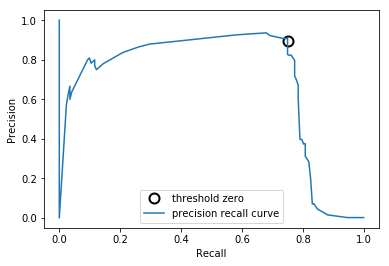

In [15]:
#5 Precision Recall Curve
precision, recall, thresholds=precision_recall_curve(y_test, gbrt_model.predict_proba(x_test)[:,1])

# Tree models have both decision_function(x_test) and predict_proba(x_test)[:,1] attribute


# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds-0.5))


plt.plot( recall[close_zero],precision[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(recall, precision, label="precision recall curve")

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best")


Average_Precision=average_precision_score(y_test, gbrt_model.predict_proba(x_test)[:,1])


print("Average Precision:\n{}".format(Average_Precision));


# The default threshold (Decision function=0 or Probabily=0.5) appears to be good
# The artifically added precision-recall pair (1,0) not really helpful in this case, as points starts at (0,0)
# Interesting shape of curve

Text(0.5, 0, 'Threashold')

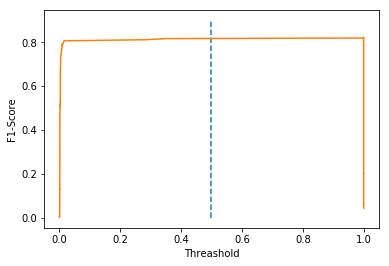

In [16]:
# 5.1 F1-Score under different Precision:

# As an example: we can have a side by side view of Precision, Recall and F1-Score for each Threshold
# SK-Learn made up a Precision=1, Recall=0 case to make the plot looks nice at the end point, in actual, this point doesn't
#   exist. As one is zero, the other is zero too. Calculation takes off this artifical point so we can have thresholds added
Information_Combine=[precision[:-1], recall[:-1], thresholds]
Information_Combine_DF=pd.DataFrame(Information_Combine)
Performance=Information_Combine_DF.T
Performance.columns=['Precision', 'Recall', 'Threshold']

Performance['F1-Score']=2*Performance['Precision']*Performance['Recall']/(Performance['Precision']+Performance['Recall'])
plt.plot([0.5, 0.5], [0, 0.9], linestyle='--')
plt.plot(Performance['Threshold'][Performance['F1-Score'].notnull()], Performance['F1-Score'][Performance['F1-Score'].notnull()])

plt.ylabel("F1-Score")
plt.xlabel("Threashold")

# The threashold bringing the highest F1-Score is ok with default probability 0.5

AUC score w Unbalanced data:
0.9096734485120612


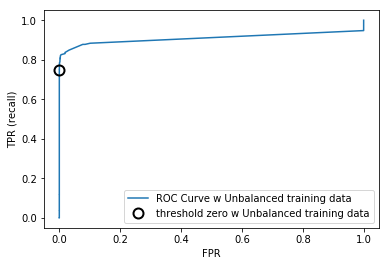

In [17]:
#6. AUC curve and Score

fpr, tpr, thresholds = roc_curve(y_test, gbrt_model.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label="ROC Curve w Unbalanced training data")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds-0.5))

plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero w Unbalanced training data", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

auc=roc_auc_score(y_test,  gbrt_model.predict_proba(x_test)[:,1])

print("AUC score w Unbalanced data:\n{}".format(auc))


Text(0, 0.5, 'True probability with Test data')

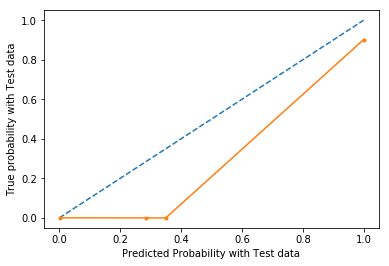

In [18]:
#7. Calibration Curve/ Reliability Diagram

# Test set predicted probabily
probs=gbrt_model_fitted.predict_proba(x_test)[:,1] # Probility Estimate
prob_true, prob_pred=calibration_curve(y_test, probs, n_bins=10, normalize=True)


# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(prob_pred, prob_true, marker='.')


plt.xlabel("Predicted Probability with Test data")
plt.ylabel("True probability with Test data")


# the plot shows model is not well calibrated

## #8.Fit and improve the model with Calibrated prediction

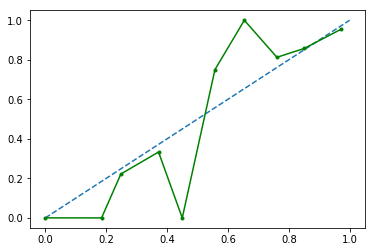

In [19]:
# Calibration classifier/model, built in additional to other models.
# With this class, the base_estimator is fit on the train set of the cross-validation generator and 
#      the test set is used for calibration. The probabilities for each of the folds are then averaged for prediction.

calibrated=CalibratedClassifierCV(gbrt_model, method='isotonic', cv=5) 
calibrated.fit(x_train, y_train) # fit calibration model

probs_Ca = calibrated.predict_proba(x_test)[:, 1]


prob_true_Ca, prob_pred_Ca=calibration_curve(y_test, probs_Ca, n_bins=10, normalize=True)


# plot perfectly calibrated- the diagnal
plt.plot([0, 1], [0, 1], linestyle='--')  # graph 1
# plot calibrated reliability
plt.plot(prob_pred_Ca, prob_true_Ca, marker='.', color='green') # graph 2

# Calibrated cross-validation didn't improve test set calibration, though it found me a model with best calibration 
#     based on the train/validation set.

In [20]:

print("Classification report with uncalibrated model")
print(classification_report(y_test, gbrt_predict))

print("")

print("Classification report with calibrated model")
calibrated_predict=calibrated.fit(x_train, y_train).predict(x_test)
print(classification_report(y_test, calibrated_predict))

# Results are very similar before and after calibration

Classification report with uncalibrated model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.90      0.75      0.82       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.95      0.87      0.91     99683
weighted avg       1.00      1.00      1.00     99683


Classification report with calibrated model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.93      0.78      0.85       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.97      0.89      0.93     99683
weighted avg       1.00      1.00      1.00     99683



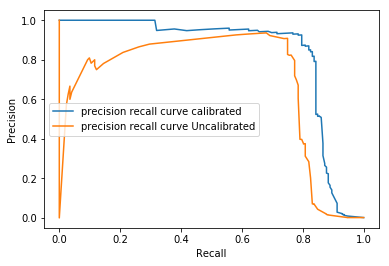

In [21]:
precision_Ca, recall_Ca, thresholds_Ca=precision_recall_curve(y_test, calibrated.predict_proba(x_test)[:, 1])

plt.plot(recall_Ca, precision_Ca, label="precision recall curve calibrated")
plt.plot(recall, precision, label="precision recall curve Uncalibrated")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')



AUC score w Calibrated data:
0.965423420526374
AUC score w Uncalibrated data:
0.9096734485120612


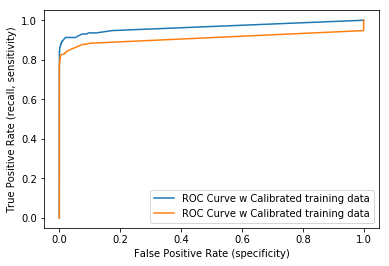

In [22]:
# ROC Curve

fpr_Ca, tpr_Ca, thresholds_Ca = roc_curve(y_test, calibrated.predict_proba(x_test)[:, 1])
plt.plot(fpr_Ca, tpr_Ca, label="ROC Curve w Calibrated training data")

plt.plot(fpr, tpr, label="ROC Curve w Calibrated training data")


plt.xlabel("False Positive Rate (specificity)")
plt.ylabel("True Positive Rate (recall, sensitivity)")

plt.legend()


auc_Ca=roc_auc_score(y_test,  calibrated.predict_proba(x_test)[:, 1])
auc=roc_auc_score(y_test,  gbrt_model.predict_proba(x_test)[:,1])

print("AUC score w Calibrated data:\n{}".format(auc_Ca))
print("AUC score w Uncalibrated data:\n{}".format(auc))

Conclusion:

In our gradient boosted tree model, 
1. Grid-search Cross-Validation recommended model did not perform well 
2. Calibrated model significantly improved model performance through observing ROC curve and Precision-Recall curve

Therefore, we will choose calibration to improve our Gradient Boosted tree model performance